### PROJETO 3 - VAE com Fashion MNIST

Este notebook apresenta uma das duas partes do Projeto 3, focando no uso do dataset Fashion MNIST. O objetivo é explorar e entender o funcionamento dos Modelos Autoencoders Variacionais (VAEs) e sua aplicação em datasets rotulados. As etapas realizadas são descritas a seguir:

#### Seleção do Dataset
- **Dataset Escolhido**: Fashion MNIST, um dataset amplamente utilizado para tarefas de aprendizado de máquina e visão computacional. Consiste em imagens de 10 categorias diferentes de roupas e acessórios, como camisetas, calças, pulôveres, entre outros.

#### Treinamento do Modelo VAE
- **Construção e Ajuste do Modelo**: O modelo VAE foi construído e ajustado para este dataset específico.
   - **Estrutura do Modelo**: O modelo consiste em duas partes principais, o encoder e o decoder. O encoder é responsável por mapear as imagens de entrada para um espaço latente, enquanto o decoder reconstrói as imagens a partir deste espaço.
   - **Dimensionalidade**: As imagens foram achatadas para vetores de 784 elementos (28x28 pixels) e a dimensão latente foi definida como 20.
   - **Camadas e Ativações**: Usamos camadas densas com ativação ReLU e a última camada do decoder com ativação sigmóide.

#### Ajuste do Melhor Modelo
- **Função de Custo e Validação**: A função de custo utilizada foi a soma do erro de reconstrução (binary crossentropy) e a divergência KL. Esta combinação ajuda a balancear a fidelidade da reconstrução com a regularização do espaço latente.
- **Treinamento e Validação**: O modelo foi treinado com o conjunto de treinamento e validado usando um conjunto de validação derivado do dataset Fashion MNIST.

#### Exploração do Espaço Latente
- **Projeção em 2D com PCA**: Após o treinamento, utilizamos o PCA (Principal Component Analysis) para projetar as representações latentes em um espaço 2D, facilitando a visualização e interpretação dos resultados.
- **Uso dos Rótulos na Projeção**: Cada ponto na projeção 2D foi etiquetado com o rótulo correspondente da categoria de vestuário, permitindo uma análise visual da distribuição das categorias no espaço latente.


---

### Análise Comparativa do Espaço Latente dos Modelos VAE para Fashion MNIST

Este notebook documenta uma análise comparativa detalhada do espaço latente resultante de dois modelos VAE diferentes treinados no dataset Fashion MNIST. Os gráficos a seguir representam as projeções 2D do espaço latente para o modelo inicial e o modelo otimizado.

#### Projeção 2D do Espaço Latente do Modelo Inicial
Verificar no notebook um pouco abaixo. É a primeira projeçao.

#### Projeção 2D do Espaço Latente do Modelo Otimizado
Verificar no notebook um pouco abaixo. É a segunda projeçao.

#### Formação de Clusters
- **Modelo Inicial**: Apresenta uma formação de clusters que, embora sobrepostos, indicam uma tendência de agrupamento por categorias de roupas.
- **Modelo Otimizado**: Os clusters são mais definidos e apresentam uma separação mais clara, sugerindo uma melhor codificação das características distintas das categorias no espaço latente.

#### Separação dos Rótulos
- **Modelo Inicial**: A separação dos rótulos é relativamente difusa, com muitas sobreposições entre as categorias.
- **Modelo Otimizado**: Observa-se uma melhoria na separação dos rótulos, com grupos mais distintos correspondendo às categorias de vestuário. Isso sugere uma representação latente mais discriminativa após a otimização.

#### Variância Capturada pela Projeção
- A projeção PCA em ambos os modelos ilustra uma parte significativa da variância. Contudo, o modelo otimizado parece capturar uma maior variância intraclasse, o que pode ser um indicativo de uma melhor representação latente dos dados.

#### Considerações Finais
As melhorias observadas no modelo otimizado, como resultado do processo de seleção e ajuste realizado com o Optuna, realçam a importância de uma sintonia fina na arquitetura do VAE. A otimização levou a um espaço latente que não só proporciona melhores visualizações, mas também pode oferecer um desempenho aprimorado em tarefas downstream, como classificação e geração de imagens. Estes resultados sublinham o potencial de modelos VAE bem ajustados para a criação de representações latentes robustas e úteis para análises complexas de dados.



In [ ]:
!pip install tensorflow optuna matplotlib scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

# Carregando o dataset Fashion-MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalizando os dados para o intervalo [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Achatar as imagens para vetores de 28*28 = 784 elementos
x_train = x_train.reshape((len(x_train), -1))
x_test = x_test.reshape((len(x_test), -1))

# imprimindo as dimensões para verificar se está correto
print(x_train.shape, x_test.shape)


4422102/4422102 [==============================] - 1s 0us/step
(60000, 784) (10000, 784)


In [ ]:
def build_vae(input_shape, latent_dim, intermediate_dims):
    # Encoder
    inputs = Input(shape=input_shape, name='encoder_input')
    x = inputs
    for intermediate_dim in intermediate_dims:
        x = Dense(intermediate_dim, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)


    # Função para amostrar do espaço latente
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # Encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

    # Decoder
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = latent_inputs
    for intermediate_dim in reversed(intermediate_dims):
        x = Dense(intermediate_dim, activation='relu')(x)
    outputs = Dense(input_shape[0], activation='sigmoid')(x)

    # Decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')

    # VAE model
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='vae_mlp')

    # VAE loss
    reconstruction_loss = binary_crossentropy(inputs, outputs) * input_shape[0]
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')

    return encoder, decoder, vae

# Criando o VAE
encoder, decoder, vae = build_vae((784,), latent_dim=20, intermediate_dims=[256])


# Resumo do modelo
encoder.summary()
decoder.summary()
vae.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 784)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  200960    ['encoder_input[0][0]']       
                                                                                                  
 z_mean (Dense)              (None, 20)                   5140      ['dense[0][0]']               
                                                                                                  
 z_log_var (Dense)           (None, 20)                   5140      ['dense[0][0]']               
                                                                                            

In [ ]:
#Treinamento VAE Simples para testar

# Parâmetros de treinamento
epochs = 15
batch_size = 256

# Treinamento do modelo
vae.fit(x_train, x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))


Epoch 1/15
235/235 [==============================] - 7s 8ms/step - loss: 312.8518 - val_loss: 274.0730
Epoch 2/15
235/235 [==============================] - 1s 6ms/step - loss: 265.6434 - val_loss: 262.3207
Epoch 3/15
235/235 [==============================] - 1s 6ms/step - loss: 257.7445 - val_loss: 257.8029
Epoch 4/15
235/235 [==============================] - 1s 6ms/step - loss: 253.8148 - val_loss: 253.6622
Epoch 5/15
235/235 [==============================] - 1s 6ms/step - loss: 251.4539 - val_loss: 252.1136
Epoch 6/15
235/235 [==============================] - 1s 6ms/step - loss: 249.8911 - val_loss: 250.3888
Epoch 7/15
235/235 [==============================] - 2s 7ms/step - loss: 248.5707 - val_loss: 249.9203
Epoch 8/15
235/235 [==============================] - 2s 8ms/step - loss: 247.5230 - val_loss: 248.9756
Epoch 9/15
235/235 [==============================] - 2s 7ms/step - loss: 246.7254 - val_loss: 247.6066
Epoch 10/15
235/235 [==============================] - 1s 6ms/st

79/79 [==============================] - 0s 3ms/step


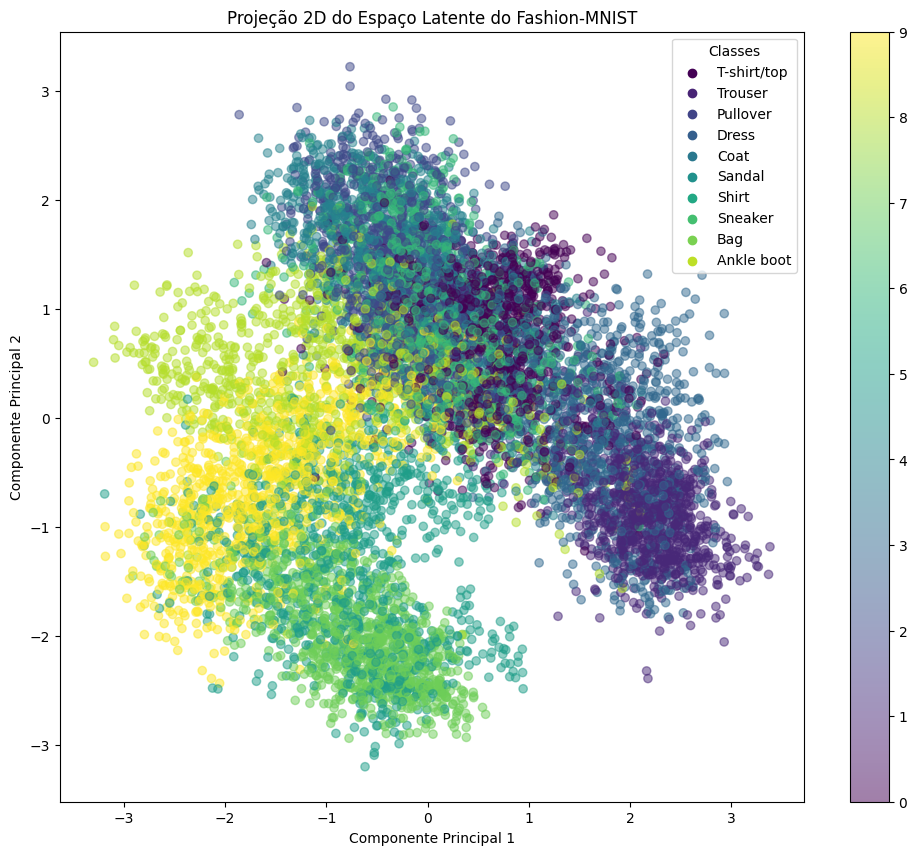

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Definir o tamanho do batch para previsão
batch_size = 128

# Obtendo as representações latentes
z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)

# Usando PCA para reduzir a dimensionalidade para 2D
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_mean)

# Plotando a projeção do espaço latente
plt.figure(figsize=(12, 10))

# Mapeamento de rótulos numéricos para os nomes das classes
labels_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# Convertendo os rótulos numéricos em nomes de classes
label_names = np.vectorize(labels_map.get)(y_test)

scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=y_test, alpha=0.5, cmap='viridis')
plt.colorbar(scatter)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Projeção 2D do Espaço Latente do Fashion-MNIST')

# Adicionando legendas com os nomes das classes
for i, label in labels_map.items():
    plt.scatter([], [], label=label, color=plt.cm.viridis(i / 10))

plt.legend(title='Classes')
plt.show()


In [ ]:
import optuna
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate
from tqdm.auto import tqdm

# Definindo a função de objetivo do VAE para o Optuna
def vae_objective(trial):
    # Hiperparâmetros do Optuna
    num_layers = trial.suggest_int('num_layers', 1, 4)
    latent_dim = trial.suggest_int('latent_dim', 1, 20)
    intermediate_dims = [trial.suggest_int(f'intermediate_dim_{i}', 128, 1024, log=True) for i in range(num_layers)]
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256, 512])
    epochs = 30  # Pode ser fixo ou também otimizado pelo Optuna

    # Construção do modelo VAE com os hiperparâmetros sugeridos
    encoder, decoder, vae = build_vae((784,), latent_dim=latent_dim, intermediate_dims=intermediate_dims)

    # Treinamento do modelo
    history = vae.fit(x_train, x_train,
                      epochs=epochs,
                      batch_size=batch_size,
                      validation_data=(x_test, x_test),
                      verbose=0)  # verbose=0 para não imprimir o progresso

    # Retorna a última perda de validação
    val_loss = history.history['val_loss'][-1]
    return val_loss

# Definindo um nome para o estudo e habilitando o progress bar
study_name = 'mnist_vae_optimization'  # Nome do estudo
study = optuna.create_study(direction='minimize', study_name=study_name)

# Callback para acompanhar o progresso
def print_progress(study, trial):
    last_value = trial.value if trial.value is not None else float('nan')
    print(f"Trial {trial.number}: val_loss = {last_value:.3f}, params = {trial.params}")

# Função de progresso personalizada
def optuna_progress_bar(study, trial):
    bar.update(1)

# Inicializando o progress bar
bar = tqdm(total=30, desc=study_name)

# Otimizando com progress bar e print callback
study.optimize(vae_objective, n_trials=30, callbacks=[print_progress, optuna_progress_bar])

# Fechando o progress bar
bar.close()

# Mostrar os melhores hiperparâmetros
print(f"Melhores hiperparâmetros: {study.best_params}")




[I 2023-12-21 01:16:17,606] A new study created in memory with name: mnist_vae_optimization


mnist_vae_optimization:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-12-21 01:17:41,790] Trial 0 finished with value: 239.48912048339844 and parameters: {'num_layers': 2, 'latent_dim': 7, 'intermediate_dim_0': 324, 'intermediate_dim_1': 310, 'batch_size': 128}. Best is trial 0 with value: 239.48912048339844.


Trial 0: val_loss = 239.489, params = {'num_layers': 2, 'latent_dim': 7, 'intermediate_dim_0': 324, 'intermediate_dim_1': 310, 'batch_size': 128}


[I 2023-12-21 01:20:48,842] Trial 1 finished with value: 256.6214904785156 and parameters: {'num_layers': 3, 'latent_dim': 2, 'intermediate_dim_0': 170, 'intermediate_dim_1': 299, 'intermediate_dim_2': 495, 'batch_size': 64}. Best is trial 0 with value: 239.48912048339844.


Trial 1: val_loss = 256.621, params = {'num_layers': 3, 'latent_dim': 2, 'intermediate_dim_0': 170, 'intermediate_dim_1': 299, 'intermediate_dim_2': 495, 'batch_size': 64}


[I 2023-12-21 01:22:09,431] Trial 2 finished with value: 240.9254150390625 and parameters: {'num_layers': 2, 'latent_dim': 6, 'intermediate_dim_0': 235, 'intermediate_dim_1': 175, 'batch_size': 128}. Best is trial 0 with value: 239.48912048339844.


Trial 2: val_loss = 240.925, params = {'num_layers': 2, 'latent_dim': 6, 'intermediate_dim_0': 235, 'intermediate_dim_1': 175, 'batch_size': 128}


[I 2023-12-21 01:22:52,417] Trial 3 finished with value: 240.51364135742188 and parameters: {'num_layers': 1, 'latent_dim': 17, 'intermediate_dim_0': 988, 'batch_size': 256}. Best is trial 0 with value: 239.48912048339844.


Trial 3: val_loss = 240.514, params = {'num_layers': 1, 'latent_dim': 17, 'intermediate_dim_0': 988, 'batch_size': 256}


[I 2023-12-21 01:26:16,578] Trial 4 finished with value: 243.84519958496094 and parameters: {'num_layers': 2, 'latent_dim': 4, 'intermediate_dim_0': 281, 'intermediate_dim_1': 182, 'batch_size': 64}. Best is trial 0 with value: 239.48912048339844.


Trial 4: val_loss = 243.845, params = {'num_layers': 2, 'latent_dim': 4, 'intermediate_dim_0': 281, 'intermediate_dim_1': 182, 'batch_size': 64}


[I 2023-12-21 01:27:41,280] Trial 5 finished with value: 243.2742156982422 and parameters: {'num_layers': 4, 'latent_dim': 7, 'intermediate_dim_0': 976, 'intermediate_dim_1': 138, 'intermediate_dim_2': 397, 'intermediate_dim_3': 515, 'batch_size': 256}. Best is trial 0 with value: 239.48912048339844.


Trial 5: val_loss = 243.274, params = {'num_layers': 4, 'latent_dim': 7, 'intermediate_dim_0': 976, 'intermediate_dim_1': 138, 'intermediate_dim_2': 397, 'intermediate_dim_3': 515, 'batch_size': 256}


[I 2023-12-21 01:29:06,282] Trial 6 finished with value: 240.45726013183594 and parameters: {'num_layers': 2, 'latent_dim': 8, 'intermediate_dim_0': 261, 'intermediate_dim_1': 131, 'batch_size': 128}. Best is trial 0 with value: 239.48912048339844.


Trial 6: val_loss = 240.457, params = {'num_layers': 2, 'latent_dim': 8, 'intermediate_dim_0': 261, 'intermediate_dim_1': 131, 'batch_size': 128}


[I 2023-12-21 01:30:30,502] Trial 7 finished with value: 241.04029846191406 and parameters: {'num_layers': 1, 'latent_dim': 8, 'intermediate_dim_0': 717, 'batch_size': 128}. Best is trial 0 with value: 239.48912048339844.


Trial 7: val_loss = 241.040, params = {'num_layers': 1, 'latent_dim': 8, 'intermediate_dim_0': 717, 'batch_size': 128}


[I 2023-12-21 01:32:54,950] Trial 8 finished with value: 239.59132385253906 and parameters: {'num_layers': 3, 'latent_dim': 9, 'intermediate_dim_0': 563, 'intermediate_dim_1': 143, 'intermediate_dim_2': 140, 'batch_size': 128}. Best is trial 0 with value: 239.48912048339844.


Trial 8: val_loss = 239.591, params = {'num_layers': 3, 'latent_dim': 9, 'intermediate_dim_0': 563, 'intermediate_dim_1': 143, 'intermediate_dim_2': 140, 'batch_size': 128}


[I 2023-12-21 01:35:04,406] Trial 9 finished with value: 263.1184997558594 and parameters: {'num_layers': 1, 'latent_dim': 2, 'intermediate_dim_0': 230, 'batch_size': 64}. Best is trial 0 with value: 239.48912048339844.


Trial 9: val_loss = 263.118, params = {'num_layers': 1, 'latent_dim': 2, 'intermediate_dim_0': 230, 'batch_size': 64}


[I 2023-12-21 01:35:48,214] Trial 10 finished with value: 242.18435668945312 and parameters: {'num_layers': 4, 'latent_dim': 14, 'intermediate_dim_0': 444, 'intermediate_dim_1': 908, 'intermediate_dim_2': 957, 'intermediate_dim_3': 132, 'batch_size': 512}. Best is trial 0 with value: 239.48912048339844.


Trial 10: val_loss = 242.184, params = {'num_layers': 4, 'latent_dim': 14, 'intermediate_dim_0': 444, 'intermediate_dim_1': 908, 'intermediate_dim_2': 957, 'intermediate_dim_3': 132, 'batch_size': 512}


[I 2023-12-21 01:37:21,410] Trial 11 finished with value: 239.02593994140625 and parameters: {'num_layers': 3, 'latent_dim': 12, 'intermediate_dim_0': 455, 'intermediate_dim_1': 389, 'intermediate_dim_2': 134, 'batch_size': 128}. Best is trial 11 with value: 239.02593994140625.


Trial 11: val_loss = 239.026, params = {'num_layers': 3, 'latent_dim': 12, 'intermediate_dim_0': 455, 'intermediate_dim_1': 389, 'intermediate_dim_2': 134, 'batch_size': 128}


[I 2023-12-21 01:38:55,508] Trial 12 finished with value: 238.87364196777344 and parameters: {'num_layers': 3, 'latent_dim': 13, 'intermediate_dim_0': 409, 'intermediate_dim_1': 439, 'intermediate_dim_2': 132, 'batch_size': 128}. Best is trial 12 with value: 238.87364196777344.


Trial 12: val_loss = 238.874, params = {'num_layers': 3, 'latent_dim': 13, 'intermediate_dim_0': 409, 'intermediate_dim_1': 439, 'intermediate_dim_2': 132, 'batch_size': 128}


[I 2023-12-21 01:39:24,700] Trial 13 finished with value: 241.0811309814453 and parameters: {'num_layers': 3, 'latent_dim': 13, 'intermediate_dim_0': 431, 'intermediate_dim_1': 580, 'intermediate_dim_2': 128, 'batch_size': 512}. Best is trial 12 with value: 238.87364196777344.


Trial 13: val_loss = 241.081, params = {'num_layers': 3, 'latent_dim': 13, 'intermediate_dim_0': 431, 'intermediate_dim_1': 580, 'intermediate_dim_2': 128, 'batch_size': 512}


[I 2023-12-21 01:41:49,384] Trial 14 finished with value: 242.76988220214844 and parameters: {'num_layers': 4, 'latent_dim': 19, 'intermediate_dim_0': 581, 'intermediate_dim_1': 507, 'intermediate_dim_2': 209, 'intermediate_dim_3': 1014, 'batch_size': 128}. Best is trial 12 with value: 238.87364196777344.


Trial 14: val_loss = 242.770, params = {'num_layers': 4, 'latent_dim': 19, 'intermediate_dim_0': 581, 'intermediate_dim_1': 507, 'intermediate_dim_2': 209, 'intermediate_dim_3': 1014, 'batch_size': 128}


[I 2023-12-21 01:43:24,141] Trial 15 finished with value: 240.1028289794922 and parameters: {'num_layers': 3, 'latent_dim': 12, 'intermediate_dim_0': 419, 'intermediate_dim_1': 454, 'intermediate_dim_2': 225, 'batch_size': 128}. Best is trial 12 with value: 238.87364196777344.


Trial 15: val_loss = 240.103, params = {'num_layers': 3, 'latent_dim': 12, 'intermediate_dim_0': 419, 'intermediate_dim_1': 454, 'intermediate_dim_2': 225, 'batch_size': 128}


[I 2023-12-21 01:44:54,729] Trial 16 finished with value: 241.74441528320312 and parameters: {'num_layers': 3, 'latent_dim': 16, 'intermediate_dim_0': 128, 'intermediate_dim_1': 706, 'intermediate_dim_2': 213, 'batch_size': 128}. Best is trial 12 with value: 238.87364196777344.


Trial 16: val_loss = 241.744, params = {'num_layers': 3, 'latent_dim': 16, 'intermediate_dim_0': 128, 'intermediate_dim_1': 706, 'intermediate_dim_2': 213, 'batch_size': 128}


[I 2023-12-21 01:45:27,186] Trial 17 finished with value: 242.21322631835938 and parameters: {'num_layers': 4, 'latent_dim': 11, 'intermediate_dim_0': 577, 'intermediate_dim_1': 372, 'intermediate_dim_2': 172, 'intermediate_dim_3': 133, 'batch_size': 512}. Best is trial 12 with value: 238.87364196777344.


Trial 17: val_loss = 242.213, params = {'num_layers': 4, 'latent_dim': 11, 'intermediate_dim_0': 577, 'intermediate_dim_1': 372, 'intermediate_dim_2': 172, 'intermediate_dim_3': 133, 'batch_size': 512}


[I 2023-12-21 01:46:18,643] Trial 18 finished with value: 240.15188598632812 and parameters: {'num_layers': 3, 'latent_dim': 15, 'intermediate_dim_0': 364, 'intermediate_dim_1': 245, 'intermediate_dim_2': 299, 'batch_size': 256}. Best is trial 12 with value: 238.87364196777344.


Trial 18: val_loss = 240.152, params = {'num_layers': 3, 'latent_dim': 15, 'intermediate_dim_0': 364, 'intermediate_dim_1': 245, 'intermediate_dim_2': 299, 'batch_size': 256}


[I 2023-12-21 01:48:43,465] Trial 19 finished with value: 238.20431518554688 and parameters: {'num_layers': 2, 'latent_dim': 19, 'intermediate_dim_0': 500, 'intermediate_dim_1': 379, 'batch_size': 128}. Best is trial 19 with value: 238.20431518554688.


Trial 19: val_loss = 238.204, params = {'num_layers': 2, 'latent_dim': 19, 'intermediate_dim_0': 500, 'intermediate_dim_1': 379, 'batch_size': 128}


[I 2023-12-21 01:50:05,667] Trial 20 finished with value: 238.21412658691406 and parameters: {'num_layers': 2, 'latent_dim': 20, 'intermediate_dim_0': 710, 'intermediate_dim_1': 695, 'batch_size': 128}. Best is trial 19 with value: 238.20431518554688.


Trial 20: val_loss = 238.214, params = {'num_layers': 2, 'latent_dim': 20, 'intermediate_dim_0': 710, 'intermediate_dim_1': 695, 'batch_size': 128}


[I 2023-12-21 01:51:30,480] Trial 21 finished with value: 238.54417419433594 and parameters: {'num_layers': 2, 'latent_dim': 20, 'intermediate_dim_0': 708, 'intermediate_dim_1': 691, 'batch_size': 128}. Best is trial 19 with value: 238.20431518554688.


Trial 21: val_loss = 238.544, params = {'num_layers': 2, 'latent_dim': 20, 'intermediate_dim_0': 708, 'intermediate_dim_1': 691, 'batch_size': 128}


[I 2023-12-21 01:52:55,605] Trial 22 finished with value: 238.43634033203125 and parameters: {'num_layers': 2, 'latent_dim': 20, 'intermediate_dim_0': 719, 'intermediate_dim_1': 920, 'batch_size': 128}. Best is trial 19 with value: 238.20431518554688.


Trial 22: val_loss = 238.436, params = {'num_layers': 2, 'latent_dim': 20, 'intermediate_dim_0': 719, 'intermediate_dim_1': 920, 'batch_size': 128}


[I 2023-12-21 01:54:21,389] Trial 23 finished with value: 238.1331024169922 and parameters: {'num_layers': 2, 'latent_dim': 18, 'intermediate_dim_0': 789, 'intermediate_dim_1': 1007, 'batch_size': 128}. Best is trial 23 with value: 238.1331024169922.


Trial 23: val_loss = 238.133, params = {'num_layers': 2, 'latent_dim': 18, 'intermediate_dim_0': 789, 'intermediate_dim_1': 1007, 'batch_size': 128}


[I 2023-12-21 01:55:45,298] Trial 24 finished with value: 240.13504028320312 and parameters: {'num_layers': 1, 'latent_dim': 18, 'intermediate_dim_0': 836, 'batch_size': 128}. Best is trial 23 with value: 238.1331024169922.


Trial 24: val_loss = 240.135, params = {'num_layers': 1, 'latent_dim': 18, 'intermediate_dim_0': 836, 'batch_size': 128}


[I 2023-12-21 01:57:09,475] Trial 25 finished with value: 238.6272735595703 and parameters: {'num_layers': 2, 'latent_dim': 18, 'intermediate_dim_0': 535, 'intermediate_dim_1': 977, 'batch_size': 128}. Best is trial 23 with value: 238.1331024169922.


Trial 25: val_loss = 238.627, params = {'num_layers': 2, 'latent_dim': 18, 'intermediate_dim_0': 535, 'intermediate_dim_1': 977, 'batch_size': 128}


[I 2023-12-21 01:57:52,688] Trial 26 finished with value: 240.00927734375 and parameters: {'num_layers': 2, 'latent_dim': 16, 'intermediate_dim_0': 806, 'intermediate_dim_1': 759, 'batch_size': 512}. Best is trial 23 with value: 238.1331024169922.


Trial 26: val_loss = 240.009, params = {'num_layers': 2, 'latent_dim': 16, 'intermediate_dim_0': 806, 'intermediate_dim_1': 759, 'batch_size': 512}


[I 2023-12-21 02:00:03,382] Trial 27 finished with value: 240.80184936523438 and parameters: {'num_layers': 1, 'latent_dim': 18, 'intermediate_dim_0': 642, 'batch_size': 64}. Best is trial 23 with value: 238.1331024169922.


Trial 27: val_loss = 240.802, params = {'num_layers': 1, 'latent_dim': 18, 'intermediate_dim_0': 642, 'batch_size': 64}


[I 2023-12-21 02:01:27,556] Trial 28 finished with value: 238.5808868408203 and parameters: {'num_layers': 2, 'latent_dim': 20, 'intermediate_dim_0': 848, 'intermediate_dim_1': 561, 'batch_size': 256}. Best is trial 23 with value: 238.1331024169922.


Trial 28: val_loss = 238.581, params = {'num_layers': 2, 'latent_dim': 20, 'intermediate_dim_0': 848, 'intermediate_dim_1': 561, 'batch_size': 256}


[I 2023-12-21 02:02:51,746] Trial 29 finished with value: 239.30003356933594 and parameters: {'num_layers': 2, 'latent_dim': 16, 'intermediate_dim_0': 326, 'intermediate_dim_1': 816, 'batch_size': 128}. Best is trial 23 with value: 238.1331024169922.


Trial 29: val_loss = 239.300, params = {'num_layers': 2, 'latent_dim': 16, 'intermediate_dim_0': 326, 'intermediate_dim_1': 816, 'batch_size': 128}
Melhores hiperparâmetros: {'num_layers': 2, 'latent_dim': 18, 'intermediate_dim_0': 789, 'intermediate_dim_1': 1007, 'batch_size': 128}


In [ ]:
!pip install plotly

import plotly
print(plotly.__version__)


5.15.0


In [ ]:
#Usando o modo offline do ploty, ja que o outro nao funcinou.

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [ ]:
!pip install "notebook>=5.3" "ipywidgets>=7.2"
!jupyter nbextension enable --py widgetsnbextension


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.8 MB/s eta 0:00:00
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [ ]:
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate
import plotly


# Plotando o histórico da otimização
fig1 = plot_optimization_history(study)
fig1.show()

# Plotando coordenadas paralelas dos hiperparâmetros
fig2 = plot_parallel_coordinate(study)
fig2.show()


In [ ]:
#Salvar estudo Optune
import joblib

joblib.dump(study, 'study.pkl')


['study.pkl']

Epoch 1/15
469/469 [==============================] - 15s 15ms/step - loss: 277.6752
Epoch 2/15
469/469 [==============================] - 7s 14ms/step - loss: 250.1254
Epoch 3/15
469/469 [==============================] - 3s 6ms/step - loss: 246.3312
Epoch 4/15
469/469 [==============================] - 3s 6ms/step - loss: 244.3682
Epoch 5/15
469/469 [==============================] - 3s 6ms/step - loss: 242.9420
Epoch 6/15
469/469 [==============================] - 4s 8ms/step - loss: 241.8700
Epoch 7/15
469/469 [==============================] - 3s 6ms/step - loss: 241.0913
Epoch 8/15
469/469 [==============================] - 3s 6ms/step - loss: 240.3932
Epoch 9/15
469/469 [==============================] - 3s 6ms/step - loss: 239.7835
Epoch 10/15
469/469 [==============================] - 4s 8ms/step - loss: 239.3119
Epoch 11/15
469/469 [==============================] - 3s 7ms/step - loss: 239.0422
Epoch 12/15
469/469 [==============================] - 3s 6ms/step - loss: 238.688

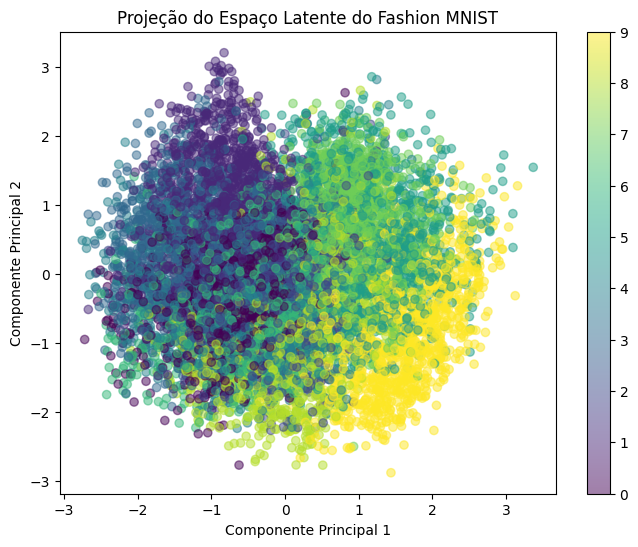

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# 1. Construir o modelo VAE com os melhores hiperparâmetros
best_params = study.best_params

# Extraindo o número de camadas e as dimensões intermediárias
num_layers = best_params['num_layers']
intermediate_dims = [best_params[f'intermediate_dim_{i}'] for i in range(num_layers)]

encoder, decoder, vae = build_vae(
    input_shape=(784,),
    latent_dim=best_params['latent_dim'],
    intermediate_dims=intermediate_dims
)



# 2. Treinar modelo com o conjunto de dados completo
vae.fit(x_train, x_train, epochs=15, batch_size=best_params['batch_size'])

# 3. Projeção do espaço latente em 2D
z_mean, _, _ = encoder.predict(x_test, batch_size=best_params['batch_size'])
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_mean)
plt.figure(figsize=(8, 6))
plt.scatter(z_pca[:, 0], z_pca[:, 1], c=y_test, alpha=0.5, cmap='viridis')
plt.colorbar()
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Projeção do Espaço Latente do Fashion MNIST')
plt.show()






1/1 [==============================] - 0s 16ms/step


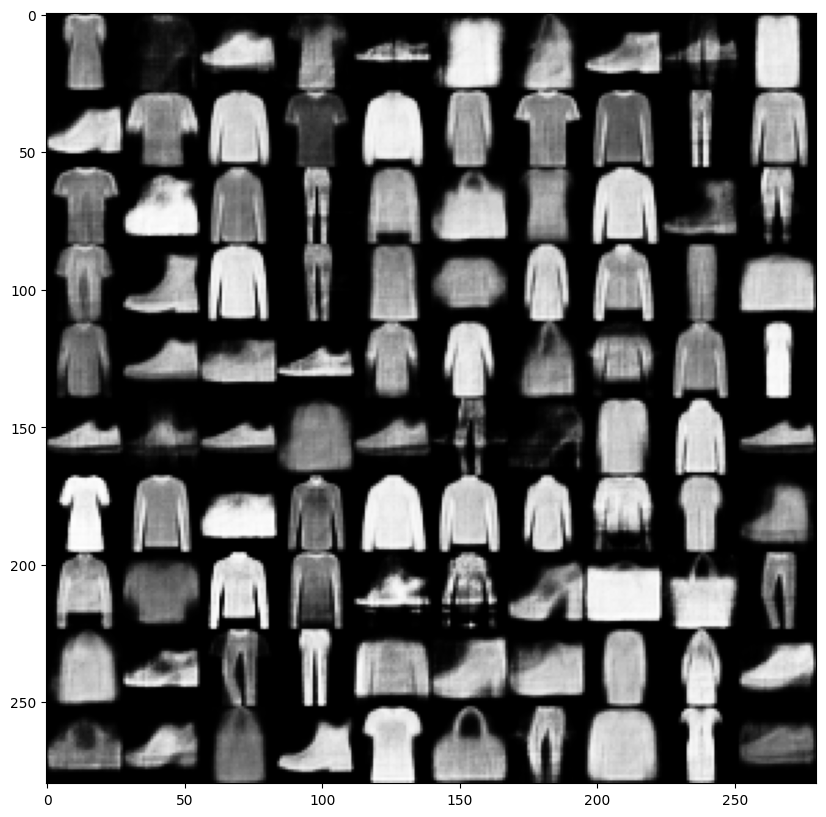

In [ ]:
n = 10  # número de imagens para gerar
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))


#latent_dim = best_params['latent_dim']
latent_dim = 18

# Amostra aleatória de pontos no espaço latente
# Assegurando que cada ponto z_sample tenha a dimensão correta
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        # Aqui nós criamos um vetor latente com a dimensão correta
        z_sample = np.random.normal(size=(1, latent_dim))
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.grid(False)
plt.show()
